## Упражнение 23.1 (Надёжный маршрут)

М-р Умник ездит на работу на автомобиле. Закончив в своё время полный курс исследования операций, он легко определил самый короткий путь от дома до работы. К сожалению на данном маршруте находится достаточно много камер, и Умнику часто приходят штрафы за превышение скорости (как ему кажется, необоснованно). Таким образом самый короткий путь оказался не самым лучшим. Схема сети дорог, по которой м-р Умник может добраться от дома до работы, приведена ниже. На этой схеме приведены вероятности попасться в объектив камеры. Требуется определить такой маршрут, вероятность проскочить на котором будет максимальной. (Подсказка: удобней складывать логарифмы вероятностей, чем перемножать исходные значения)


задача:

нахождения максимальной вероятности скипнуть камеры

проблема:

при перемножении маленьких чисел терятется точность RFC 6340



```
P = p_1 + ... + p_n
```

Логарифмируем лево и право ->
```
 log(P) = log(p_1) + ... + log(p_2)

```

In [1]:
import networkx as nx
import math

G = nx.DiGraph()

# ..., вер-ть попадения
edges = [
    ("дом", 2, 0.15),
    (2, 3, 0.84),
    (2, 7, 0.95), 
    (2, 5, 0.56),
    (3, 4, 0.4),
    (7, 4, 0.05),
    (7, 5, 0.3),
    (4, 5, 0.32),
    (4, 6, 0.22),
    (5, 6, 0.78),
    (5, "работа", 0.88),
    (6, "работа", 0.65)
]

# делаем 1 - p_hit, чтобы найти  наикротчайший путь скипа камер
for source, target, p_hit in edges:
    weight = -math.log(1 - p_hit)
    G.add_edge(source, target, weight=weight, p_hit=p_hit)

shortest_path = nx.shortest_path(G, source="дом", target="работа", weight="weight", method="bellman-ford")

log_sum = 0
path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))

for edge in path_edges:
    source, target = edge
    log_sum += G[source][target]["weight"]

prob_escape = math.exp(-log_sum)

print("Оптимальный путь:", shortest_path)
print("Вероятность скипнуть папараций:", prob_escape)

Оптимальный путь: ['дом', 2, 5, 'работа']
Вероятность скипнуть папараций: 0.04487999999999999


[('n0', 'n1', {'weight': 4.0}), ('n0', 'n3', {'weight': 9.0}), ('n1', 'n2', {'weight': 8.0}), ('n1', 'n3', {'weight': 1.0}), ('n1', 'n4', {'weight': 2.0}), ('n2', 'n3', {'weight': 10.0}), ('n2', 'n4', {'weight': 7.0}), ('n3', 'n4', {'weight': 3.0})]


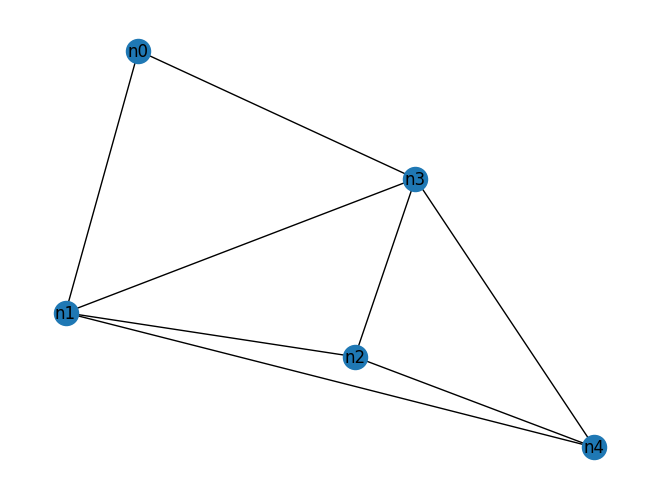

In [2]:
import networkx as nx
import numpy as np
import xml.etree.ElementTree as ET

g = nx.read_graphml("buildings.graphml")
    
pos = nx.spring_layout(g, seed=7) 
# nx.draw_networkx_labels(g, pos, font_size=20, font_family="sans-serif")
# # edge weight labels
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(g, pos, edge_labels)

nx.draw(g, with_labels=True)
print(g.edges(data=True))

In [3]:

for u, v, data in g.edges(data=True):
    if 'weight' in data:
        data['weight'] = float(data['weight'])


# Матрица смежности 
M = np.array([
    [0, 48, 23, 42, 45],
    [27, 0, 41, 32, 39],
    [30, 31, 0, 20, 36],
    [42, 32, 43, 0, 25],
    [45, 39, 47, 44, 0]
])

for u, v in g.edges():
    g[u][v]['traffic'] = 0

mx_len = len(M[0])    

# (0-4) to node IDs (n0-n4)
node_map = {i: f"n{i}" for i in range(mx_len)}

for i in range(mx_len):
    for j in range(mx_len):
        # i = j одно и то же здание || путь не существует 
        if i == j or M[i, j] <= 0:
            continue
            
        from_node = node_map[i]
        to_node = node_map[j]

        path = nx.shortest_path(g, source=from_node, target=to_node, weight='weight')
        
        path_edges = list(zip(path[:-1], path[1:]))
        
        # Add student flow to the traffic on each edge in the path
        for u, v in path_edges:
            # Check edge direction since NetworkX can store edges in either order
            if g.has_edge(u, v):
                g[u][v]['traffic'] += M[i, j]
            else:
                g[v][u]['traffic'] += M[i, j]
       

# Calculate total traffic through each vertex
node_traffic = {}
for node in g.nodes():
    total = 0
    for edge in g.edges(node):
        u, v = edge
        total += g[u][v]['traffic']
    node_traffic[node] = total

best_place = max(node_traffic, key=node_traffic.get)
max_traffic_value = node_traffic[best_place]

print(f"Best place for coffee shop: Building {best_place}")
print(f"Total traffic through this building: {max_traffic_value}")

print("\nTraffic through all buildings:")
for node, traffic in sorted(node_traffic.items()):
    print(f"Building {node}: {traffic}")

Best place for coffee shop: Building n1
Total traffic through this building: 869

Traffic through all buildings:
Building n0: 302
Building n1: 869
Building n2: 271
Building n3: 280
Building n4: 320


In [4]:
import networkx as nx

G = nx.DiGraph()

nodes = ["source", "1", "2", "3", "drain"]
G.add_nodes_from(nodes)

# (from, to, {capacity: value})
edges_with_capacities = [
    # Source to individuals (equal distribution)
    ("source", "1", {"capacity": 20}),
    ("source", "2", {"capacity": 20}),
    ("source", "3", {"capacity": 20}),
    
    # Possible transfers between individuals (unlimited capacity)
    ("1", "2", {"capacity": float('inf')}),
    ("1", "3", {"capacity": float('inf')}),
    ("2", "1", {"capacity": float('inf')}),
    ("2", "3", {"capacity": float('inf')}),
    ("3", "1", {"capacity": float('inf')}),
    ("3", "2", {"capacity": float('inf')}),
    
    # Individuals to drain (actual contributions)
    ("1", "drain", {"capacity": 10}),
    ("2", "drain", {"capacity": 40}),
    ("3", "drain", {"capacity": 10})
]

G.add_edges_from(edges_with_capacities)

flow_value, flow_dict = nx.maximum_flow(G, "source", "drain")
print(f"Total flow value: {flow_value}")

# Extract internal transfers between participants
fellas = ["1", "2", "3"]
internal_transfers = []

for from_node in fellas:
    for to_node in fellas:
        if from_node != to_node:
            flow_amount = flow_dict[from_node][to_node]
            if flow_amount > 0:
                internal_transfers.append({
                    "from": from_node,
                    "to": to_node,
                    "flow": flow_amount
                })

print("\nТребуется перевести:")
for transfer in internal_transfers:
    print(f"ФСКшник {transfer['from']} платит {transfer['flow']} тугриков {transfer['to']}")

initial_contributions = {"1": 10, "2": 40, "3": 10}
fair_share = sum(initial_contributions.values()) / 3
print(f"\nДоля на каждого: {fair_share} тугриков")

for person in fellas:
    diff = initial_contributions[person] - fair_share
    status = "переплатил" if diff > 0 else "недоплатил"
    print(f"ФСКшник {person} вложил {initial_contributions[person]} тугриков ({status} к {abs(diff)} тугриков)")

Total flow value: 60

Требуется перевести:
ФСКшник 1 платит 20 тугриков 2
ФСКшник 3 платит 10 тугриков 1

Доля на каждого: 20.0 тугриков
ФСКшник 1 вложил 10 тугриков (недоплатил к 10.0 тугриков)
ФСКшник 2 вложил 40 тугриков (переплатил к 20.0 тугриков)
ФСКшник 3 вложил 10 тугриков (недоплатил к 10.0 тугриков)


In [5]:
import pandas as pd
import numpy as np
from collections import defaultdict, deque

def sch_new():
    return {
        'activities': pd.DataFrame(columns=['id', 'name', 'duration', 'early_start', 'early_finish', 
                                          'late_start', 'late_finish', 'total_float', 'critical']),
        'relations': []
    }

def sch_add_activity(sch, activity_id, name, duration):
    new_activity = pd.DataFrame({
        'id': [activity_id],
        'name': [name], 
        'duration': [duration],
        'early_start': [0],
        'early_finish': [0],
        'late_start': [0],
        'late_finish': [0],
        'total_float': [0],
        'critical': [False]
    })
    
    sch['activities'] = pd.concat([sch['activities'], new_activity], ignore_index=True)
    return sch

def sch_add_relation(sch, from_id, to_id):
    sch['relations'].append((from_id, to_id))
    return sch

def sch_plan(sch):
    activities = sch['activities'].copy()
    relations = sch['relations']
    
    # Create adjacency lists
    predecessors = defaultdict(list)
    successors = defaultdict(list)
    
    for from_id, to_id in relations:
        predecessors[to_id].append(from_id)
        successors[from_id].append(to_id)
    
    # Forward pass - calculate early start and early finish
    def forward_pass():
        # Topological sort
        in_degree = defaultdict(int)
        for activity_id in activities['id']:
            in_degree[activity_id] = len(predecessors[activity_id])
        
        queue = deque([aid for aid in activities['id'] if in_degree[aid] == 0])
        
        while queue:
            current = queue.popleft()
            idx = activities[activities['id'] == current].index[0]
            duration = activities.loc[idx, 'duration']
            
            # Calculate early start
            if not predecessors[current]:
                activities.loc[idx, 'early_start'] = 0
            else:
                pred_finishes = []
                for pred in predecessors[current]:
                    pred_idx = activities[activities['id'] == pred].index[0]
                    pred_finishes.append(activities.loc[pred_idx, 'early_finish'])
                activities.loc[idx, 'early_start'] = max(pred_finishes)
            
            # Calculate early finish
            activities.loc[idx, 'early_finish'] = activities.loc[idx, 'early_start'] + duration
            
            # Update successors
            for successor in successors[current]:
                in_degree[successor] -= 1
                if in_degree[successor] == 0:
                    queue.append(successor)
    
    # Backward pass - calculate late start and late finish
    def backward_pass():
        # Find project end time
        project_end = activities['early_finish'].max()
        
        # Initialize tasks with no successors
        for activity_id in activities['id']:
            if not successors[activity_id]:
                idx = activities[activities['id'] == activity_id].index[0]
                activities.loc[idx, 'late_finish'] = project_end
        
        # Reverse topological sort
        out_degree = defaultdict(int)
        for activity_id in activities['id']:
            out_degree[activity_id] = len(successors[activity_id])
        
        queue = deque([aid for aid in activities['id'] if out_degree[aid] == 0])
        
        while queue:
            current = queue.popleft()
            idx = activities[activities['id'] == current].index[0]
            duration = activities.loc[idx, 'duration']
            
            # Calculate late start
            activities.loc[idx, 'late_start'] = activities.loc[idx, 'late_finish'] - duration
            
            # Update predecessors
            for pred in predecessors[current]:
                pred_idx = activities[activities['id'] == pred].index[0]
                if pd.isna(activities.loc[pred_idx, 'late_finish']) or activities.loc[pred_idx, 'late_finish'] == 0:
                    activities.loc[pred_idx, 'late_finish'] = activities.loc[idx, 'late_start']
                else:
                    activities.loc[pred_idx, 'late_finish'] = min(
                        activities.loc[pred_idx, 'late_finish'], 
                        activities.loc[idx, 'late_start']
                    )
                
                out_degree[pred] -= 1
                if out_degree[pred] == 0:
                    queue.append(pred)
    
    # Execute passes
    forward_pass()
    backward_pass()
    
    # Calculate total float and identify critical activities
    activities['total_float'] = activities['late_start'] - activities['early_start']
    activities['critical'] = activities['total_float'] == 0
    
    # Update the schedule
    sch['activities'] = activities
    return sch

# Main execution - replicating the R code
print("=== АНАЛИЗ КРИТИЧЕСКОГО ПУТИ ПРОЕКТА ===")
print("Проект: Строительство спорткомплекса")
print("Дата анализа:", "2025-05-28")
print("Аналитик: Anton-Bondarchuk")
print()

# Create new schedule
sch = sch_new()

# Define tasks
tasks = pd.DataFrame({
    'id': list(range(1, 21)),
    'name': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
             'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T'],
    'duration': [1, 2, 1, 2, 6, 10, 3, 1, 1, 5, 2, 1, 2, 4, 2, 2, 1, 7, 7, 3]
})

# Add activities to schedule
for i in range(len(tasks)):
    sch = sch_add_activity(sch, tasks.loc[i, 'id'], tasks.loc[i, 'name'], tasks.loc[i, 'duration'])

# Define dependencies
dependencies = [
    "", "", "A", "C", "B,C", "D", "F", "G", "F", "E,H", 
    "I", "F,J", "F", "L,M", "G,J", "O", "I,P", "P", "I,N", "S"
]

# Add relations to schedule
for i in range(len(dependencies)):
    if dependencies[i] == "":
        continue
    
    preds = [pred.strip() for pred in dependencies[i].split(",")]
    
    for pred in preds:
        pred_id = tasks[tasks['name'] == pred]['id'].iloc[0]
        sch = sch_add_relation(sch, pred_id, i + 1)

# Plan the schedule
sch = sch_plan(sch)

# Get critical activities
critical_activities = sch['activities'][sch['activities']['critical'] == True].copy()
critical_activities = critical_activities.sort_values('early_start')

# Create critical path string
critical_path = ' → '.join(critical_activities['name'].tolist())

print("РЕЗУЛЬТАТЫ АНАЛИЗА:")
print("="*60)
print(f"Критический путь: {critical_path}")
print(f"Продолжительность проекта: {int(sch['activities']['early_finish'].max())} дней")
print()

# Display detailed results
print("ПОДРОБНАЯ ИНФОРМАЦИЯ ПО ВСЕМ ЗАДАЧАМ:")
print("="*100)
display_df = sch['activities'].copy()
display_df = display_df.sort_values('id')

# Format the output to match R style
for _, row in display_df.iterrows():
    status = "КРИТИЧЕСКАЯ" if row['critical'] else f"Резерв: {int(row['total_float'])} дн."
    print(f"Задача {row['name']}: Дни {int(row['early_start'])}-{int(row['early_finish'])} "
          f"(продолжительность: {int(row['duration'])} дн.) - {status}")

print()
print("КРИТИЧЕСКИЕ ЗАДАЧИ (определяют срок проекта):")
print("-" * 50)
for _, activity in critical_activities.iterrows():
    print(f"  {activity['name']}: дни {int(activity['early_start'])}-{int(activity['early_finish'])}")

print()
print("ЗАДАЧИ С РЕЗЕРВОМ ВРЕМЕНИ:")
print("-" * 50)
non_critical = sch['activities'][sch['activities']['critical'] == False].copy()
non_critical = non_critical.sort_values('total_float')
for _, activity in non_critical.iterrows():
    print(f"  {activity['name']}: резерв {int(activity['total_float'])} дн. "
          f"(можно начать с {int(activity['early_start'])} по {int(activity['late_start'])} день)")

# Print the critical path result (matching R output)
print()
print("="*60)
print(f"ИТОГОВЫЙ КРИТИЧЕСКИЙ ПУТЬ: {critical_path}")
print("="*60)

=== АНАЛИЗ КРИТИЧЕСКОГО ПУТИ ПРОЕКТА ===
Проект: Строительство спорткомплекса
Дата анализа: 2025-05-28
Аналитик: Anton-Bondarchuk

РЕЗУЛЬТАТЫ АНАЛИЗА:
Критический путь: A → C → D → F → G → H → J → L → N → S → T
Продолжительность проекта: 38 дней

ПОДРОБНАЯ ИНФОРМАЦИЯ ПО ВСЕМ ЗАДАЧАМ:
Задача A: Дни 0-1 (продолжительность: 1 дн.) - КРИТИЧЕСКАЯ
Задача B: Дни 0-2 (продолжительность: 2 дн.) - Резерв: 10 дн.
Задача C: Дни 1-2 (продолжительность: 1 дн.) - КРИТИЧЕСКАЯ
Задача D: Дни 2-4 (продолжительность: 2 дн.) - КРИТИЧЕСКАЯ
Задача E: Дни 2-8 (продолжительность: 6 дн.) - Резерв: 10 дн.
Задача F: Дни 4-14 (продолжительность: 10 дн.) - КРИТИЧЕСКАЯ
Задача G: Дни 14-17 (продолжительность: 3 дн.) - КРИТИЧЕСКАЯ
Задача H: Дни 17-18 (продолжительность: 1 дн.) - КРИТИЧЕСКАЯ
Задача I: Дни 14-15 (продолжительность: 1 дн.) - Резерв: 13 дн.
Задача J: Дни 18-23 (продолжительность: 5 дн.) - КРИТИЧЕСКАЯ
Задача K: Дни 15-17 (продолжительность: 2 дн.) - Резерв: 21 дн.
Задача L: Дни 23-24 (продолжительность: 1 